In [1]:
import numpy as np
import numpy.linalg as LA
import statsmodels.api as sm
import math
from scipy import integrate
import matplotlib.pyplot as plt
import random
import time

In [2]:
def generateData(N,M): # N: individuals, M: SNPs
    X = np.zeros((M,N))
    Y = np.zeros(N)
    
    for i in range(M):
        for j in range(N):
            X[i][j] = random.randint(0,2)
    
    for j in range(N):
        Y[j] = random.randint(0,1)
    
    return X,Y

In [3]:
def data(X,Y,N,M): # X: genotype, Y: phenotype
    # type 1 allele frequency
    p = np.zeros(M)
    
    for i in range(M):
        for j in range(N):
            p[i] += X[i][j]
        p[i] /= (2*N)
        
    # empirical covariance matrix
    psi = np.zeros((N,N))
    
    for i in range(N):
        for j in range(i+1):
            for s in range(M):
                if p[s] != 0 and p[s] != 1:
                    psi[i][j] += (X[s][i] - 2*p[s])*(X[s][j] - 2*p[s])/(2*p[s]*(1-p[s]))
            psi[i][j] /= M
            psi[j][i] = psi[i][j]
    
    # PCA
    ev,pc = LA.eig(psi)
    
    ll = np.zeros((N,2))
    for i in range(N):
        ll[i][0] = ev[i].real
        ll[i][1] = i
    l = sorted(ll, key=lambda x:(x[0]), reverse=True)
    
    K = 10
    v = np.zeros((N,K))
    
    for i in range(K):
        for j in range(N):
            v[j][i] = pc[int(l[i][1])][j].real
            
    # multiple linear regression
    vv = sm.add_constant(v)
    coef = np.linalg.lstsq(vv,Y,rcond=None)[0]
    
    hatY = np.zeros(N)
    for i in range(N):
        for j in range(K+1):
            hatY[i] += (coef[j]*vv[i][j])
    starY = Y - hatY
    
    hatX = np.zeros((M,N))
    starX = np.zeros((M,N))
    for s in range(M):
        coef = np.linalg.lstsq(vv,X[s],rcond=None)[0]
        for i in range(N):
            for j in range(K+1):
                hatX[s][i] += (coef[j]*vv[i][j])
        starX[s] = X[s] - hatX[s]
    
    return starX, starY

def EIGENSTRAT(starX,starY,N,M,K):
    stats = np.zeros(M)
    for s in range(M):
        t = np.sum(starX[s]*starY)**2
        b = (np.linalg.norm(starX[s])**2) * (np.linalg.norm(starY)**2)
        stats[s] = (N-K-1)*t/b
    
    return stats

def s_EIGENSTRAT(starX,starY,N,M,K,s):
    t = np.sum(starX[s]*starY)**2
    b = (np.linalg.norm(starX[s])**2) * (np.linalg.norm(starY)**2)
    stats = (N-K-1)*t/b
    
    return stats

def pDP_EIGENSTRAT(starX,starY,N,M,K): #phenotypically DP
    stats = np.zeros(M)
    for s in range(M):
        t = (np.sum(starX[s]*starY) + np.random.laplace(loc=0.0, scale=(2*np.max(starX[s]))/epsilon, size=1))**2
        b = (np.linalg.norm(starX[s])**2)*(np.linalg.norm(starY) + np.random.laplace(loc=0.0, scale=2/epsilon, size=1))**2
        stats[s] = (N-K-1)*t/b
    
    return stats

In [4]:
def RR(epsilon,X,Y,N,M,s):
    XRR = np.zeros((M,N))
    YRR = np.zeros(N)
    
    for j in range(M):
        for i in range(N):
            XRR[j][i] = X[j][i]
    
    for i in range(N):
        rand = random.random()
        if rand >= 6/(math.exp(epsilon)+5):
            XRR[s][i] = X[s][i]
            YRR[i] = Y[i]
        else:
            g = int(rand*(math.exp(epsilon)+5))
            XRR[s][i] = int(g/2)
            YRR[i] = int(g%2)
    
    return XRR,YRR

In [5]:
def Diff(N,M,epsilon):
    K = 10
    diff = np.zeros((2,M))
    statsEG = np.zeros((M,2)); rstatsEG = np.zeros(M)
    
    X,Y = generateData(N,M)
    
    sdata = data(X,Y,N,M)
    ss = EIGENSTRAT(sdata[0],sdata[1],N,M,K)
    for i in range(M):
        statsEG[i][0] = ss[i]
        statsEG[i][1] = i
        
    for s in range(M):
        XRR,YRR = RR(epsilon,X,Y,N,M,s)
        rdata = data(XRR,YRR,N,M)
        rstatsEG[s] = s_EIGENSTRAT(rdata[0],rdata[1],N,M,K,s)
    
    pstatsEG = pDP_EIGENSTRAT(sdata[0],sdata[1],N,M,K)
    
    sstatsEG = sorted(statsEG, key=lambda x:(x[0]),reverse=True)
    sEG = np.zeros(M); rsEG = np.zeros(M); psEG = np.zeros(M)
    for i in range(M):
        sEG[i] = sstatsEG[i][0]
        
        rsEG[i] = rstatsEG[int(sstatsEG[i][1])]
        diff[0][i] = math.fabs(sEG[i]-rsEG[i])
        
        psEG[i] = pstatsEG[int(sstatsEG[i][1])]
        diff[1][i] = math.fabs(sEG[i]-psEG[i])
    
    return diff

def evaluation(N,M,epsilon):
    diff = np.zeros((2,M))
    for j in range(4):
        diff += Diff(N,M,epsilon)
    diff /= 4
    return diff

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


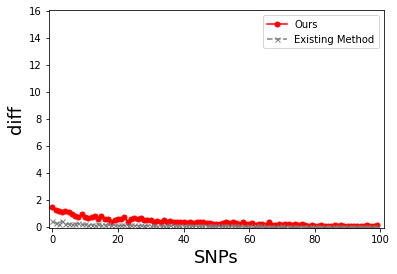

In [6]:
N = 1000; M = 100; epsilon = 5

max_diff = np.zeros((2,M)); min_diff = np.ones((2,M))*10000
sum_diff = np.zeros((2,M))

for j in range(5):
    diff = evaluation(N,M,epsilon)
    for i in range(2):
        for k in range(M):
            max_diff[i][k] = np.max([diff[i][k], max_diff[i][k]])
            min_diff[i][k] = np.min([diff[i][k], min_diff[i][k]])
            sum_diff[i][k] += diff[i][k]

diff = sum_diff / 5
y_err = np.zeros((2,2,M))
y_err[0][0] = diff[0] - min_diff[0]
y_err[1][0] = max_diff[0] - diff[0]
y_err[0][1] = diff[1] - min_diff[1]
y_err[1][1] = max_diff[1] - diff[1]
    
index = np.zeros(M)
for i in range(M):
    index[i] = i

fig = plt.figure()
plt.ylim(-0.05, 16.05)
plt.xlim(-1, 101)
#plt.errorbar(index, diff[0], yerr = y_err[:,0,:], capsize=5, fmt='o', ecolor='r', markeredgecolor = "r", color='r')
plt.plot(index, diff[0], marker="o", markersize=5, color = "r", linestyle = "-", label = "Ours")
#plt.errorbar(index, diff[1], yerr = y_err[:,1,:], capsize=5, fmt='x', ecolor='gray', markeredgecolor = "gray", color='gray')
plt.plot(index, diff[1], marker="x", markersize=5, color = "gray", linestyle = "--", label = "Existing Method")
plt.legend()
plt.xlabel("SNPs", fontsize = 18)
plt.ylabel("diff", fontsize = 18)
fig.savefig("diff_EG_N=1000_epsilon=5.png")
fig.savefig("figs/diff_EG_N=1000_epsilon=5.eps", bbox_inches="tight", pad_inches=0.05)